In [114]:
import joblib
import torch 
import pandas as pd
import numpy as np
from metpy.calc import wind_components
from metpy.units import units
import openmeteo_requests
import requests_cache
from math import radians, sin, cos, sqrt, atan2
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import datetime as dt
import pytz
from retry_requests import retry
from datetime import timedelta
import torch.nn as nn
from tensorflow.keras.models import load_model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# API

In [97]:
def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

#setting up API client
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


#Sample use
# df = get_reading("https://api.open-meteo.com/v1/forecast",
#             31.990534, 35.907787,
#             ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
#            "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 5,
#             0)

def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
    params = {
        "latitude": latitude,
        "longitude": longtitute,
        "hourly": hourly,
        "past_days": past_days,
        "forecast_days": future_days
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    # Convert from UTC to UTC+3
    start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True) + pd.Timedelta(hours=3)
    end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) + pd.Timedelta(hours=3)

    hourly_data = {
        "date": pd.date_range(
            start=start_time,
            end=end_time,
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var_name in enumerate(get_ordered_hourly_variables(params)):
        hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

    hourly_df = pd.DataFrame(data=hourly_data)
    hourly_df['Date/Time'] = pd.to_datetime(hourly_df['date'], errors='coerce')
    hourly_df.set_index('Date/Time', inplace=True)
    hourly_df.drop(columns=['date'], inplace=True)


    hourly_df.rename(columns={
        "dew_point_2m": "Air Dew Point",
        "temperature_2m": "Air Temperature (OC)",
        "relative_humidity_2m": "Humidity %",
        "pressure_msl": "Atmospheric Pressure",
        "wind_speed_10m": "Wind Speed (MPS)",
        "wind_direction_10m": "Wind Direction (Degrees)"
    }, inplace=True)

    hourly_df.index = hourly_df.index.tz_convert(None)

    u, v = wind_components(
        hourly_df['Wind Speed (MPS)'].values * units('m/s'),
        hourly_df['Wind Direction (Degrees)'].values * units.degree
    )

    hourly_df['Wind_U'] = u.magnitude  
    hourly_df['Wind_V'] = v.magnitude
    hourly_df.Wind_U = hourly_df.Wind_U.round(2)
    hourly_df.Wind_V = hourly_df.Wind_V.round(2)

    hourly_df.drop(columns=["Wind Speed (MPS)", "Wind Direction (Degrees)"], inplace=True)
    hourly_df = hourly_df[['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 'Atmospheric Pressure', 'Wind_U', 'Wind_V']]
    
    return hourly_df

# Functions

In [115]:
class RainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RainLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x) 
        return self.fc(hn[-1])  

In [98]:
#distance fucntion
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

In [99]:
def get_nearest_station(location):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
 
    coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
    ]
    lat, lon = location
    distances = []
    for stat_lat, stat_lon in coordinates:
        distances.append(haversine(lat, lon, stat_lat, stat_lon))
    closest_idx = int(np.argmin(distances))
    return names[closest_idx]

In [100]:

"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns closest station name and a single rain probability for next 24 hours
"""
def predict_rain_probability(location, df_48h, models_dir="Models/Precipitation_Models"):
    
    input_features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    #Find closest station
    station = get_nearest_station(location)

    #Load model and scaler
    scaler = joblib.load(f"{models_dir}/{station}_scaler.pkl")
    model = RainLSTM(input_size=11)
    model.load_state_dict(torch.load(f"{models_dir}/{station}_precipitation_model.pth", map_location=torch.device('cpu')))
    model.eval()

    #preprocessing 
    df = df_48h.copy()
    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    df[input_features] = scaler.transform(df[input_features])
    input_data = df[input_features].values.astype(np.float32)

    #Padding just in case
    if len(input_data) < 48:
        pad_len = 48 - len(input_data)
        padding = np.repeat(input_data[-1:], pad_len, axis=0)
        input_data = np.vstack([input_data, padding])

    input_tensor = torch.tensor(input_data).unsqueeze(0)  #shape (1, 48, 11)

    with torch.no_grad():
        prob = model(input_tensor).item()

    return {
        "closest_station": station,
        "precipitation_probability": round(prob, 4)
    }

In [105]:
"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns cloud cover for next 24 hour time stamps
"""

def predict_cloud_cover(location, df_48h):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
    coordinates = [
        (29.5500, 35.0000), (31.0333, 35.4667), (32.5500, 35.8500), (32.5000, 38.2000),
        (30.1667, 35.7833), (32.3667, 36.2500), (31.7167, 35.9833), (32.1608, 37.1539),
    ]
    
    station = get_nearest_station(location)
    input_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_input_scaler.save")
    target_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_target_scaler.save")
    model = load_model(f"Models/Cloud_Cover_Models/{station}_cloud_model.keras")

    #Preprocess input dataframe
    df = df_48h.copy()
   

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    X_input = input_scaler.transform(df[input_features])
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 48, 6)

    y_pred_scaled = model.predict(X_input)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred.flatten()  # Shape: (24,)

In [101]:

"""
This function takes a 72 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Wind_U', 'Wind_V', station name,
returns the same input features for 24 hours
"""


def predict_BatchTST_Variables(df_72h: pd.DataFrame, station: str) -> pd.DataFrame:
    input_len = 72
    output_len = 24
    model_dir = r"Models\Other_Vars"
    station_file = f"{station.replace(' ', '_')}_scaler.pkl"
    scaler_path = os.path.join(model_dir, station_file)
    final_dir = os.path.join(model_dir, station.replace(" ", "_"))
    features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
    all_features = features + cyclical
    scaler: StandardScaler = joblib.load(scaler_path)
    #Cyclical features
    df_72h['day'] = df_72h.index.day
    df_72h['month'] = df_72h.index.month
    df_72h['hour'] = df_72h.index.hour
    df_72h['day_cos'] = np.cos(2 * np.pi * df_72h['day'] / 31)
    df_72h['day_sin'] = np.sin(2 * np.pi * df_72h['day'] / 31)
    df_72h['month_cos'] = np.cos(2 * np.pi * df_72h['month'] / 12)
    df_72h['month_sin'] = np.sin(2 * np.pi * df_72h['month'] / 12)
    df_72h['hour_cos'] = np.cos(2 * np.pi * df_72h['hour'] / 24)
    df_72h['hour_sin'] = np.sin(2 * np.pi * df_72h['hour'] / 24)
    df_72h.drop(['day', 'month', 'hour'], axis=1, inplace=True)
    #Scale
    scaled = scaler.transform(df_72h[all_features])
    scaled = pd.DataFrame(scaled, columns=all_features, index=df_72h.index)
    
    last_timestamp = df_72h.index[-1]
    future_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=output_len, freq='h')
    predictions_df = pd.DataFrame(index=future_timestamps)
    
    for target_feature in features:
        print(f"Processing: {target_feature}")
    
        #Load model
        config = PatchTSTConfig(
            context_length=input_len,
            prediction_length=output_len,
            patch_len=24,
            stride=8,
            d_model=128,
            n_heads=8,
            num_encoder_layers=3,
            dropout=0.1,
            head_dropout=0.1,
            num_input_channels=len(all_features),
            num_targets=1,
            scaling="std",
        )
        model = PatchTSTForPrediction(config).to(device)
    
        model_path = os.path.join(final_dir, f"patchtst_{target_feature.replace(' ', '_')}.pt")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        inputs = scaled[all_features].values
        
        #Prediction
        x = inputs
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # [24, 12]
        y_pred_single = y_pred[:, all_features.index(target_feature)]
        y_pred_full = np.zeros((output_len, len(all_features)))
        y_pred_full[:, all_features.index(target_feature)] = y_pred_single
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]
        
        predictions_df[target_feature] = y_pred_unscaled
        
    return predictions_df

In [89]:
def TST_recursive(df_recent: pd.DataFrame, station: str):

    all_predictions = []

    current_input = df_recent.copy()

    for step in range(5):
        next_24h = predict_BatchTST_Variables(current_input, station)
        all_predictions.append(next_24h)
        current_input = pd.concat([current_input.iloc[24:], next_24h], axis=0)

    forecast_120h = pd.concat(all_predictions, axis=0)

    return forecast_120h

In [102]:
def Cloud_and_Precipitation(df_120h, location):
    all_cloud_preds = []
    #Predict cloud first
    for step in [0, 24, 48, 72, 96]:
        df_window = df_120h.iloc[step:step + 48].copy()
        cloud_preds = predict_cloud_cover(location, df_window)  
        all_cloud_preds.extend(cloud_preds)


    assert len(all_cloud_preds) == 120, f"Expected 120 cloud preds, got {len(all_cloud_preds)}"


    df_with_cloud = df_120h.copy()
    df_with_cloud['Cloud Cover %'] = 0.0  # ensure float type
    cloud_col_index = df_with_cloud.columns.get_loc('Cloud Cover %')


    df_with_cloud.iloc[-120:, cloud_col_index] = all_cloud_preds

    #predict rain probs
    rain_probs = [] 

    for step in range(0, 109, 12):  # steps: 0, 12, ..., 72
        df_window = df_with_cloud.iloc[step:step + 48].copy()
        prob = predict_rain_probability(location, df_window)["precipitation_probability"]
        rain_probs.append(prob)

    
    day_night_tuples = [
        (rain_probs[i], rain_probs[i + 1]) for i in range(0, len(rain_probs), 2)
    ]

    return {
        "cloud_cover": all_cloud_preds,           #120 values (5x24h)
        "rain_probabilities": day_night_tuples    #5 tuples (day, night)
    }

# Predict full forecast

In [109]:
def predict_full_forecast(location: tuple):
    station = get_nearest_station(location)

    past_data = get_reading("https://api.open-meteo.com/v1/forecast",
            location[0], location[1],
            ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
           "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 4,
            0)
    past_data = past_data.tail(72)
    TST_preds = TST_recursive(past_data, station)
    input_with_time = TST_preds.copy()
    input_with_time['time'] = TST_preds.index
    cloud_precipitation = Cloud_and_Precipitation(input_with_time.tail(120),location)

    time_series_outputs = TST_preds
    time_series_outputs['Cloud Cover %'] = cloud_precipitation['cloud_cover']

    forecast = {
        "time_series" : time_series_outputs,
        'rain_probabilities' : cloud_precipitation['rain_probabilities']
    }
    return forecast

In [116]:
hh = predict_full_forecast((31.990534, 35.907787))

Processing: Air Dew Point
Processing: Air Temperature (OC)
Processing: Humidity %
Processing: Atmospheric Pressure
Processing: Wind_U
Processing: Wind_V
Processing: Air Dew Point
Processing: Air Temperature (OC)
Processing: Humidity %
Processing: Atmospheric Pressure
Processing: Wind_U
Processing: Wind_V
Processing: Air Dew Point
Processing: Air Temperature (OC)
Processing: Humidity %
Processing: Atmospheric Pressure
Processing: Wind_U
Processing: Wind_V
Processing: Air Dew Point
Processing: Air Temperature (OC)
Processing: Humidity %
Processing: Atmospheric Pressure
Processing: Wind_U
Processing: Wind_V
Processing: Air Dew Point
Processing: Air Temperature (OC)
Processing: Humidity %
Processing: Atmospheric Pressure
Processing: Wind_U
Processing: Wind_V
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [118]:
hh['time_series']

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V,Cloud Cover %
2025-05-14 03:00:00,4.609606,15.916401,56.603662,1009.676291,14.653659,3.866742,49.750530
2025-05-14 04:00:00,4.484636,15.577247,56.129457,1009.639378,14.273258,4.434927,46.517673
2025-05-14 05:00:00,4.444914,15.774111,55.213518,1009.532926,13.530006,4.196736,45.207806
2025-05-14 06:00:00,4.244712,16.362200,53.253021,1009.434609,13.221616,4.854420,45.485172
2025-05-14 07:00:00,4.302839,17.638578,50.581657,1009.367853,13.784117,5.143501,47.933022
...,...,...,...,...,...,...,...
2025-05-18 22:00:00,4.307596,20.183827,53.456587,1009.430505,17.820384,6.990699,42.847393
2025-05-18 23:00:00,4.298046,19.404731,53.256691,1009.431122,18.096761,6.993813,45.149815
2025-05-19 00:00:00,4.292854,18.540046,53.228670,1009.446911,18.053610,6.946523,46.394039
2025-05-19 01:00:00,4.286796,17.554586,53.348536,1009.452395,18.102907,6.902547,43.282112


In [119]:
hh['rain_probabilities']

[(0.3989, 0.8587),
 (0.7748, 0.9022),
 (0.5484, 0.8948),
 (0.6546, 0.4858),
 (0.5714, 0.9803)]

In [121]:
def plot_each_column(df: pd.DataFrame, title_prefix: str = ""):
    """
    Plots each numerical column in the DataFrame on a separate subplot.

    Parameters:
    - df: DataFrame with datetime index and multiple numerical columns.
    - title_prefix: Optional prefix for subplot titles.
    """
    num_cols = df.select_dtypes(include='number').columns
    n = len(num_cols)

    if n == 0:
        print("No numerical columns to plot.")
        return

    # Create subplots
    fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, col in enumerate(num_cols):
        axes[i].plot(df.index, df[col], label=col)
        axes[i].set_title(f"{title_prefix}{col}")
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].legend()

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

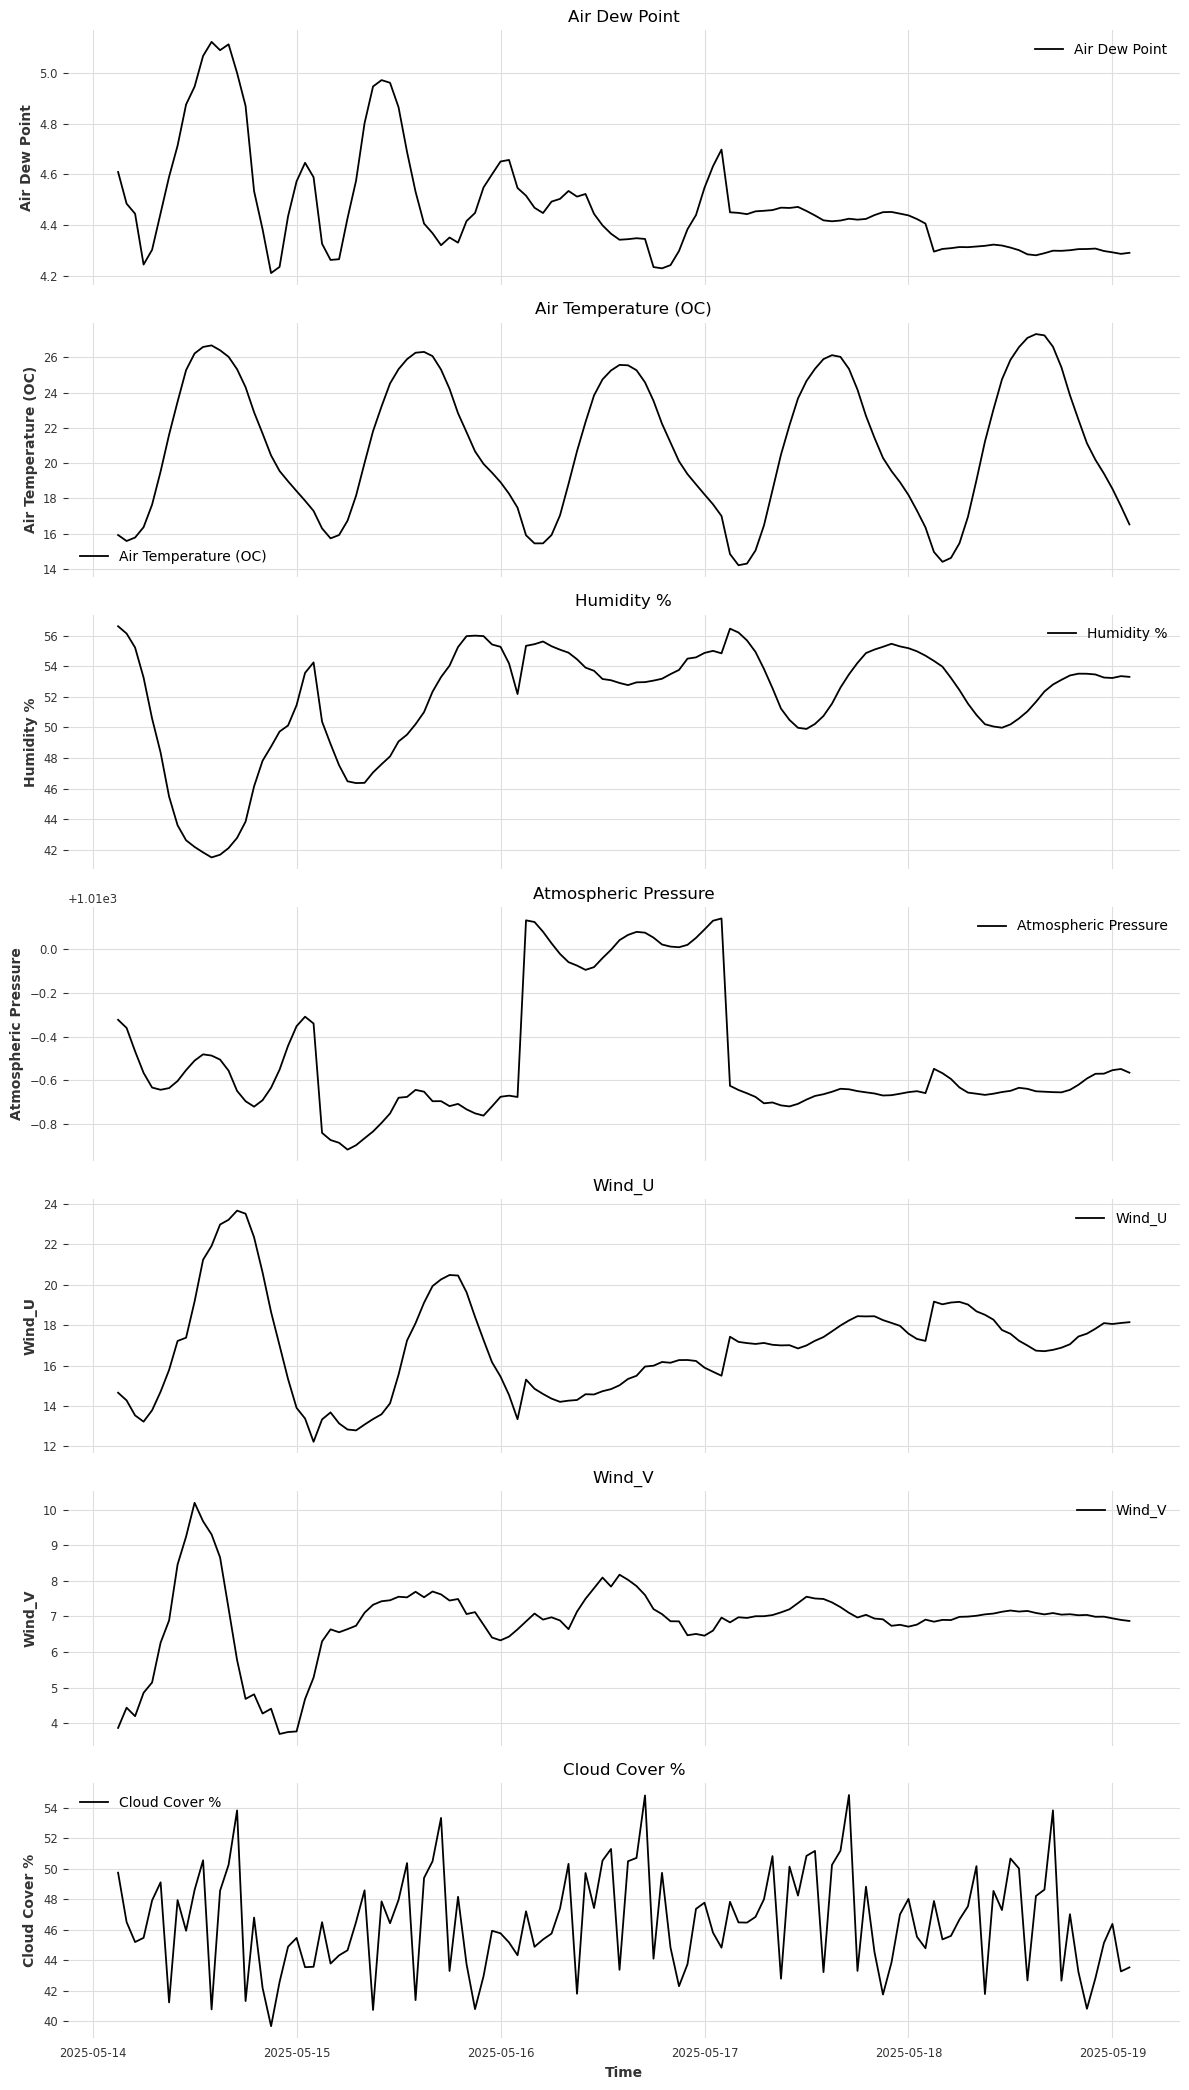

In [123]:
plot_each_column(hh['time_series'])